In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import itertools

from typing import List
from collections import OrderedDict
from pathlib import Path
from tqdm import tqdm
from skimage.color import label2rgb

from src.utils import FileHandler, mask2mat, bounding_box
from src.data.writers import HDF5Writer

# set paths
img_path = Path("/home/leos/Dippa/datasets/data/sartorius/train")
label_path = Path("/home/leos/Dippa/datasets/data/sartorius/labels")

f = img_path.parent / "train.csv"
data_train = pd.read_csv(f)
imgs = sorted(img_path.glob("*"))

# unique cell lines
cell_lines = list(enumerate(pd.unique(data_train.cell_type), 1))
cell_lines = OrderedDict((line[1], line[0]) for line in cell_lines)

In [54]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


# def binary_mask_to_rle(binary_mask):
#     rle = {'counts': [], 'size': list(binary_mask.shape)}
#     counts = rle.get('counts')
#     for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
#         if i == 0 and value == 1:
#             counts.append(0)
#         counts.append(len(list(elements)))
#     return rle


# def rle_encode(img):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     pixels = img.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)


def write_masks(
        imgs: List[Path],
        data_train: pd.DataFrame,
        save_dir: str
    ) -> None:
    """
    Convert the rle masks to numpy nd.ararys and write to .mat files
    
    Args:
    ---------
        imgs: (List[Path]):
            PosixPath-objects for each img file in a list
        data_train (pd.DataFrame):
            The train masks dataframe containing the rle encoded masks.
        save_dir (str):
            directory where the .mat files are saved
    """    
    for im_path in tqdm(imgs):
        id_ = im_path.name[:-4]
        
        img = FileHandler.read_img(im_path)
        imdata = data_train[data_train.id == id_]
        
        insts = np.zeros(img.shape[:2])
        types = np.zeros(img.shape[:2])
        
        for i, row in imdata.iterrows():
            rle = row.annotation
            w = row.width
            h = row.height
            cell_line = row.cell_type
            
            inst = rle_decode(rle, (h, w))
            
            # fill holes. (crop first to save mem, time and nerves)
            y1, y2, x1, x2 = bounding_box(inst)
            y1 = y1 - 2 if y1 - 2 >= 0 else y1
            x1 = x1 - 2 if x1 - 2 >= 0 else x1
            x2 = x2 + 2 if x2 + 2 <= insts.shape[1] - 1 else x2
            y2 = y2 + 2 if y2 + 2 <= insts.shape[0] - 1 else y2
            crop = inst[y1:y2, x1:x2]
            
            crop = ndi.binary_fill_holes(crop)
            inst[y1:y2, x1:x2] = crop
            
            insts[inst > 0] = i
            types[inst > 0] = int(cell_lines[cell_line])
        
        fn = im_path.with_suffix(".mat").name
        mask2mat(insts, types, fname=fn, save_dir=save_dir)

In [55]:
write_masks(imgs, data_train, label_path)

100%|██████████| 606/606 [02:19<00:00,  4.34it/s]


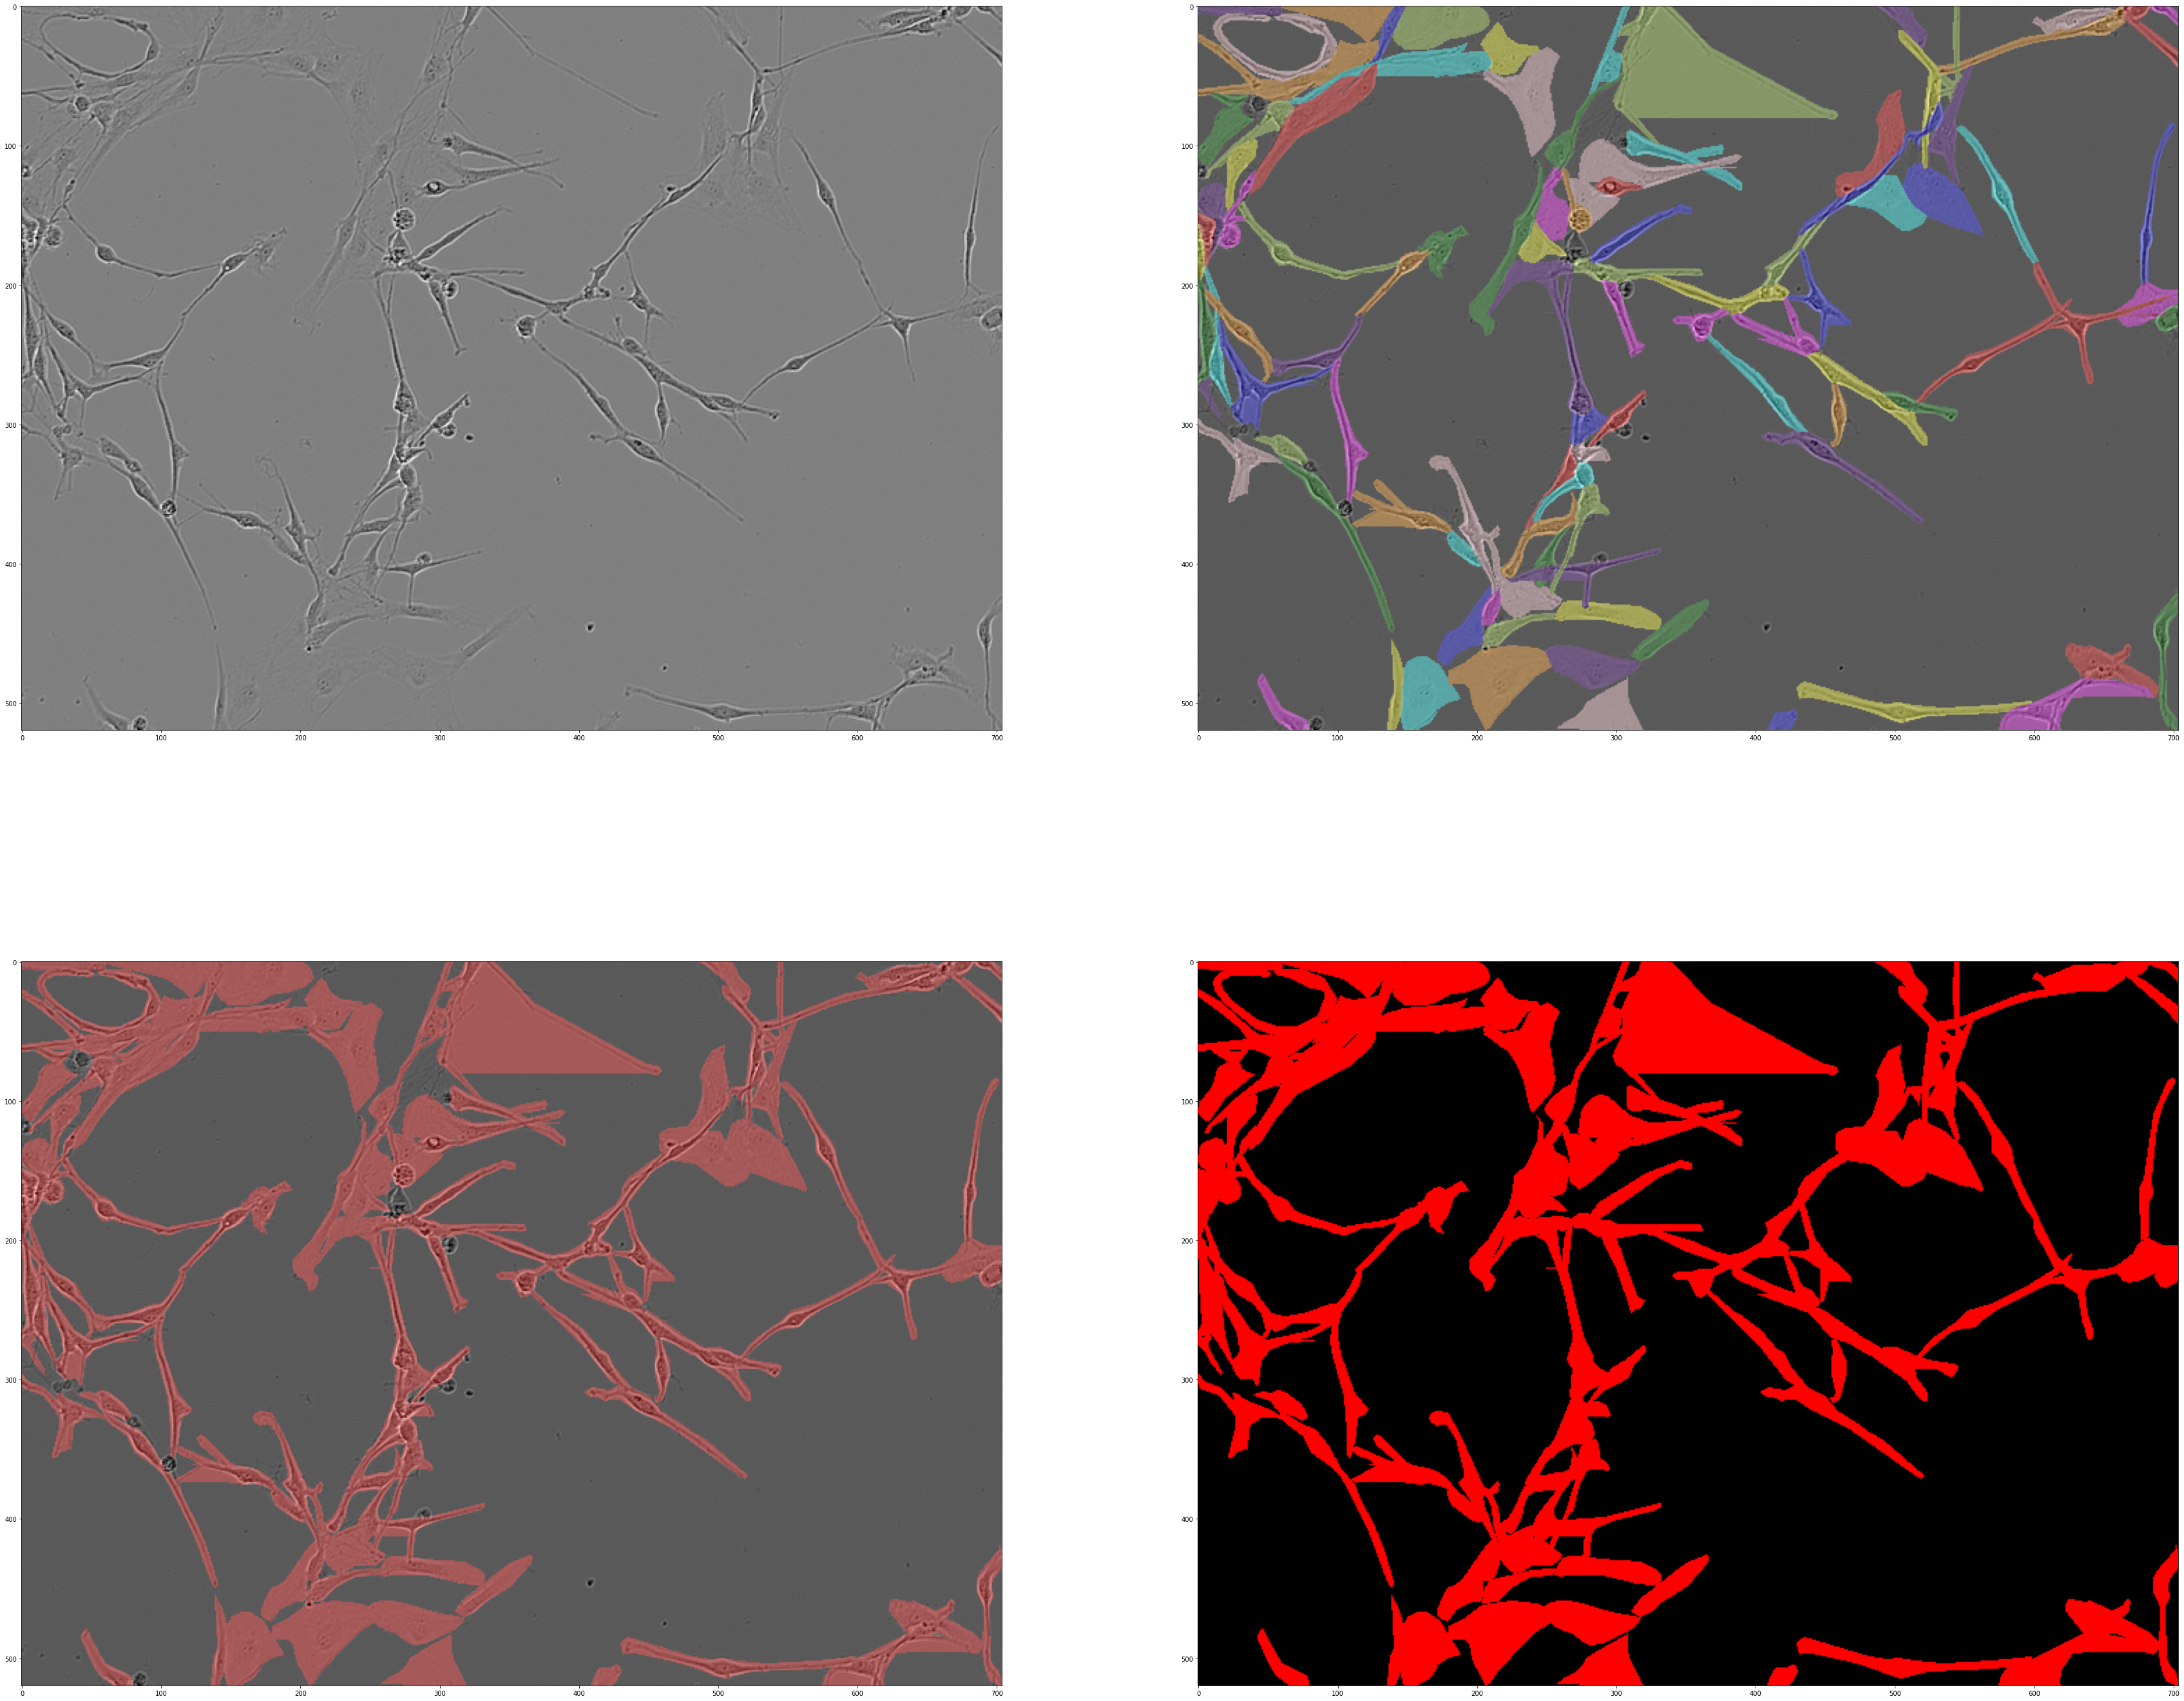

In [3]:
labels = sorted(label_path.glob("*"))

ix = 1
img = FileHandler.read_img(imgs[ix])
inst_map = FileHandler.read_mask(labels[ix], "inst_map")
type_map = FileHandler.read_mask(labels[ix], "type_map")

fig, ax = plt.subplots(2, 2, figsize=(60, 50))
ax = ax.flatten()
ax[0].imshow(img)
ax[1].imshow(label2rgb(inst_map, image=img, bg_label=0))
ax[2].imshow(label2rgb(type_map, image=img, bg_label=0))
ax[3].imshow(label2rgb(type_map, bg_label=0))

In [26]:
# Write images to (256x256) overlapping patches with stride 60 into a hdf5 database

writer = HDF5Writer(
    img_dir=img_path,
    mask_dir=label_path,
    save_dir=img_path.parent,
    file_name="sartorius_dummyval.h5",
    classes=dict(cell_lines),
    patch_shape=(256, 256),
    stride_size=256,
    rigid_augs_and_crop=False,
)

writer.write2db()

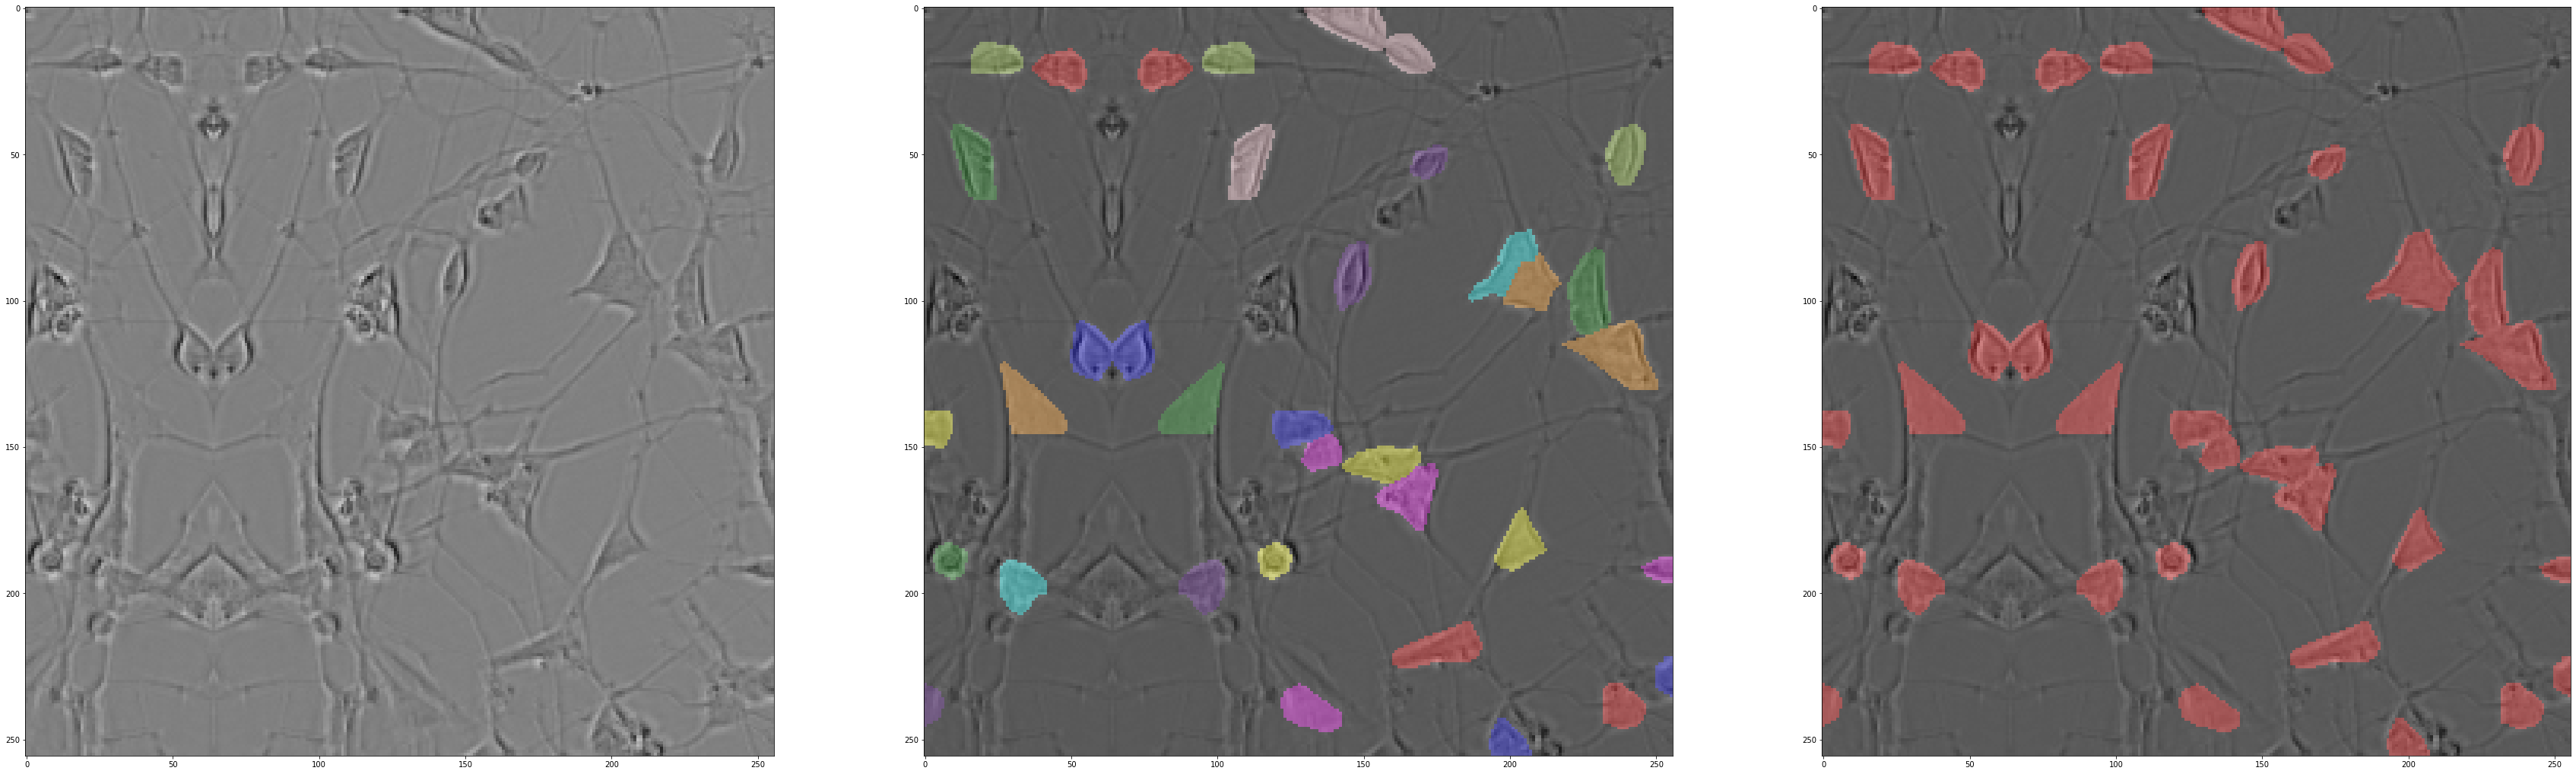

In [28]:
h5 = img_path.parent / "sartorius_dummyval.h5"

img, insts, types, _ = FileHandler.read_h5_patch(h5, ix=506)

fig, ax = plt.subplots(1, 3, figsize=(60, 50))
ax = ax.flatten()
ax[0].imshow(img)
ax[1].imshow(label2rgb(insts, image=img, bg_label=0))
ax[2].imshow(label2rgb(types, image=img, bg_label=0))